In [20]:
!pip install tqdm
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from itertools import islice
from tqdm import tqdm
import pickle
import torch
from torchvision import transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import time
from torchvision import datasets, transforms
#from google.colab import drive

1006.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [21]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='~/datasets', train=True, transform=transform, download=True)
#SVHN(root='~/datasets', split='train', transform=transform, download=True)
batch_size = 1024
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6007015.16it/s]


Extracting /Users/ricobenning/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /Users/ricobenning/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 164745.24it/s]


Extracting /Users/ricobenning/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/ricobenning/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1393760.55it/s]


Extracting /Users/ricobenning/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/ricobenning/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2297458.85it/s]

Extracting /Users/ricobenning/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/ricobenning/datasets/MNIST/raw



In [22]:
def plot_samples(images, labels):
    fig = plt.figure(figsize=(20, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.3)

    for ax, im, label in zip(grid, images, labels):
        # im = im.permute(1, 2, 0)
        # im = im.detach().cpu().numpy()
        # ax.imshow(im)
        # ax.axis('off')
        # ax.set_title(f'{label}')
        if im.shape[0] == 3:  # Check if the image has three channels
            im = torch.mean(im, dim=0, keepdim=True)  # Average across the color channels
        im = im.squeeze(0)  # Remove channel dimension for grayscale image
        im = im.detach().cpu().numpy()
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        ax.set_title(f'{label}')

    plt.show()

num_samples = 50
random_idxs = np.random.choice(np.arange(len(train_dataset)), size=num_samples, replace=False)
# print train_dataset dimensions, number of samples and plot samples
print(f'Dataset shape: {train_dataset.data.shape}')
print(f'Number of samples in dataset: {len(train_dataset)}')
images = [train_dataset[i][0] for i in random_idxs]
labels = [train_dataset[i][1] for i in random_idxs]

plot_samples(images, labels)

# changing to monochromatic, each picture is stored as a (x, 3, 32, 32), where x is the number of pictures and 3 is the number of channels.
# the chanels need to be averaged to get a monochromatic picture.
# this is done by taking the mean of the 3 channels (R, G, B) and storing it in the first channel.:

# for i in range(10):
#     train_dataset.data[i] = train_dataset.data[i].mean(0)

Dataset shape: torch.Size([60000, 28, 28])
Number of samples in dataset: 60000


### Helper functions to save and load models

Images with label 1 shape: torch.Size([5949, 1, 28, 28])
Number of images with label 1: 5949


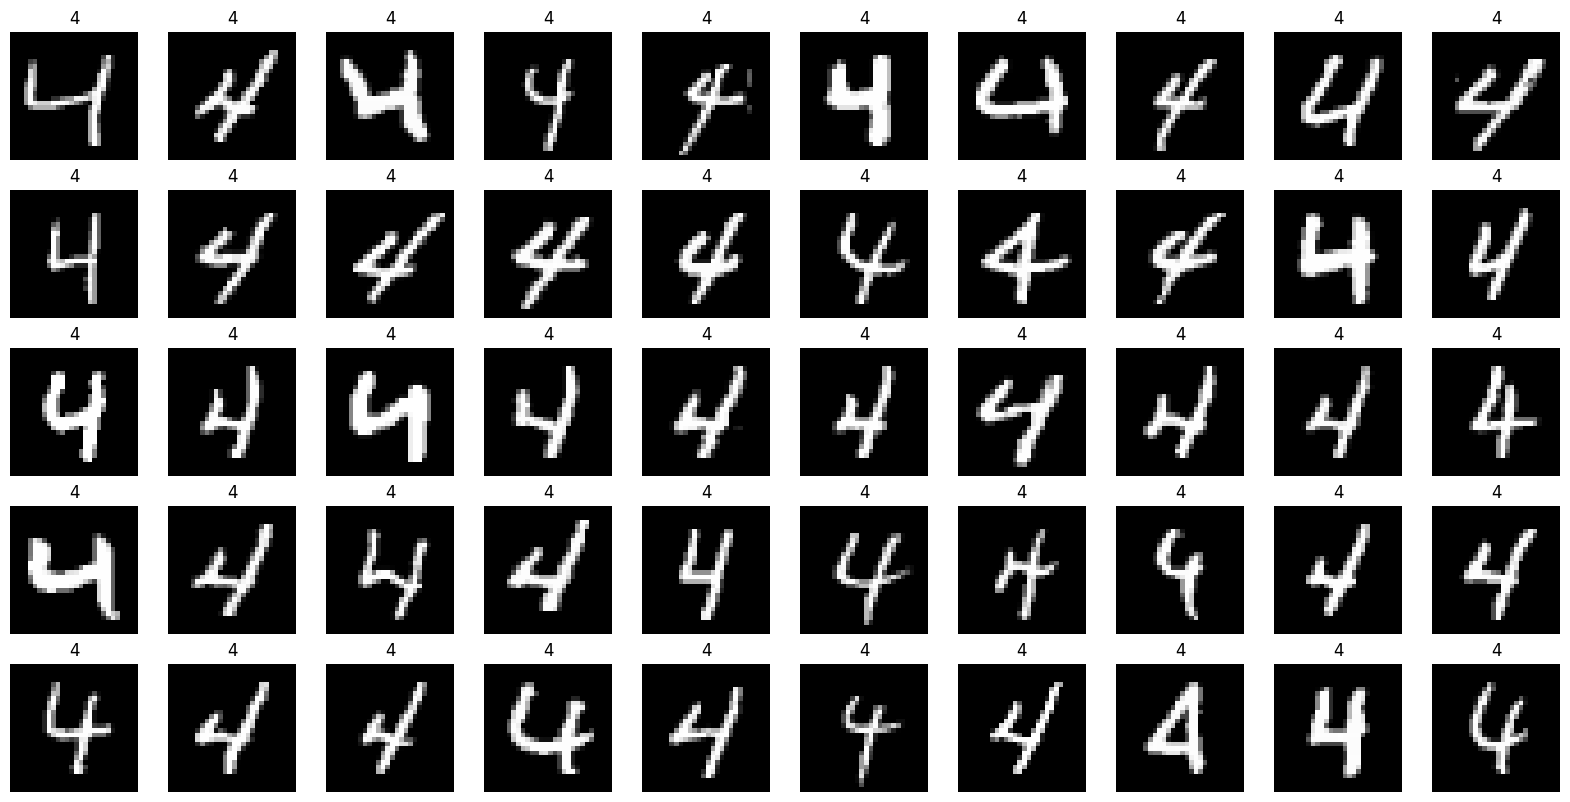

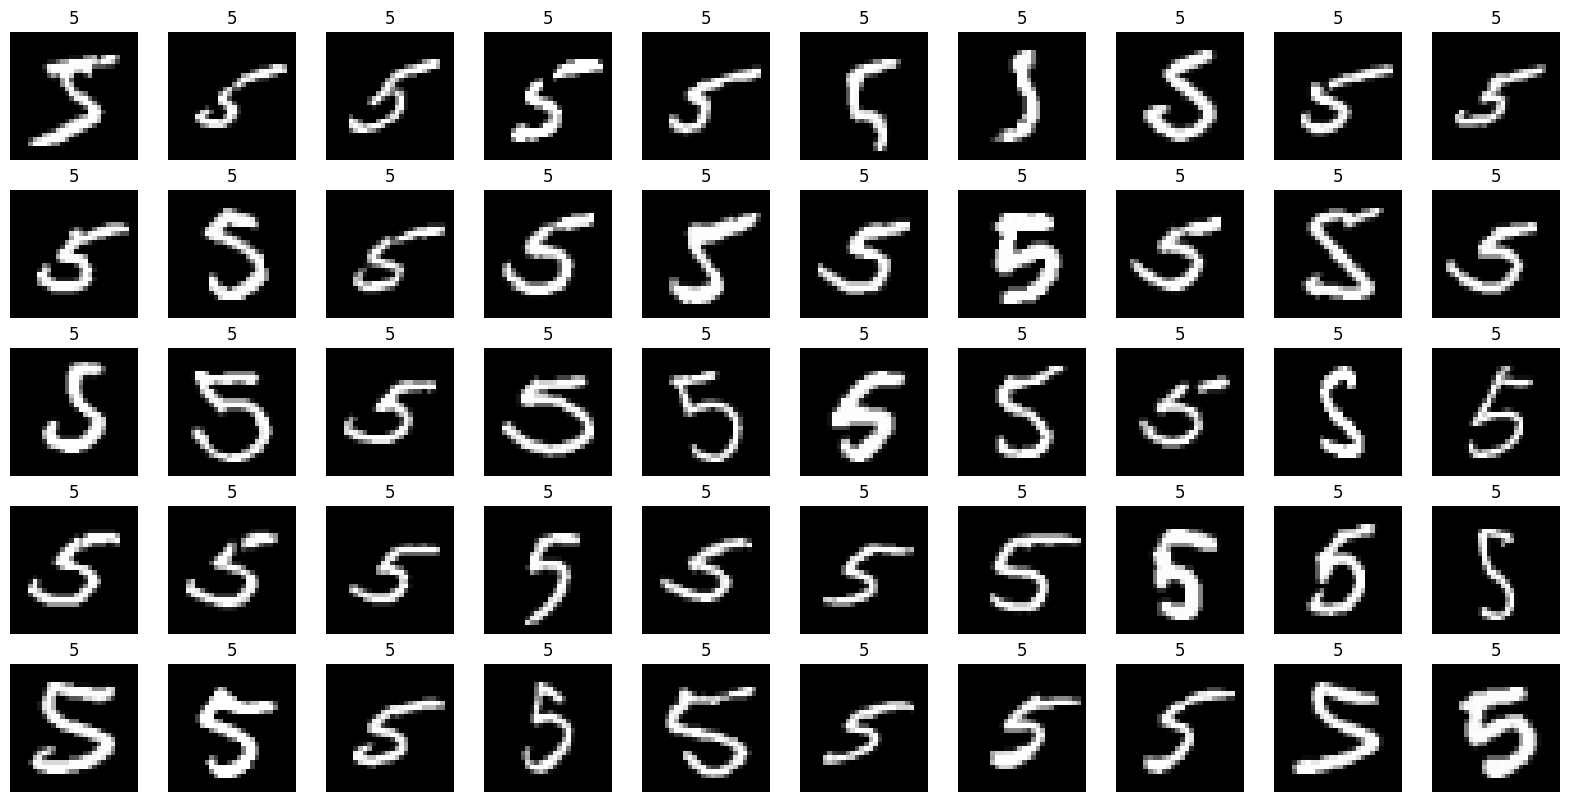

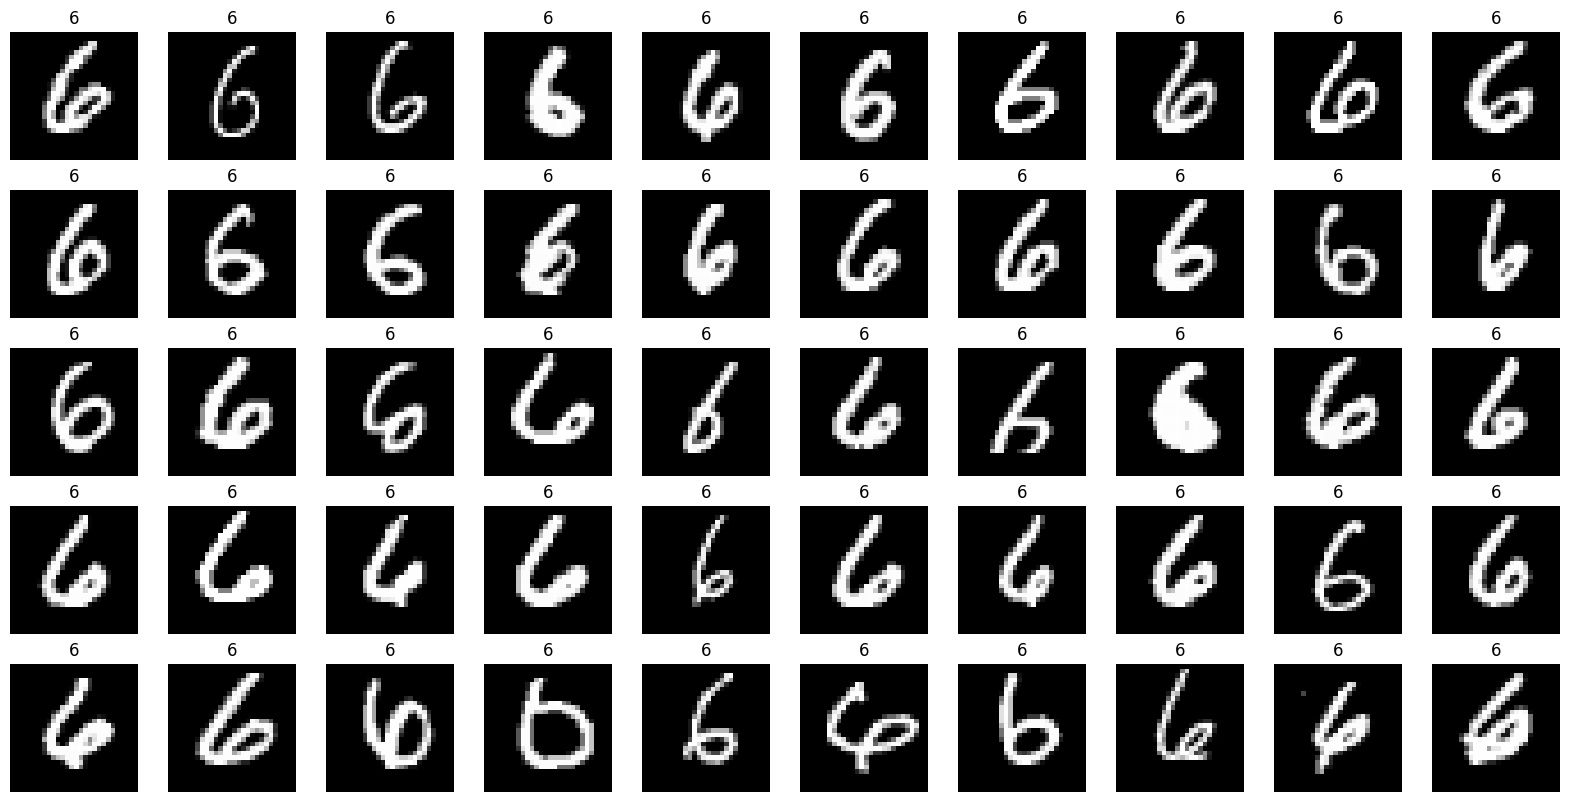

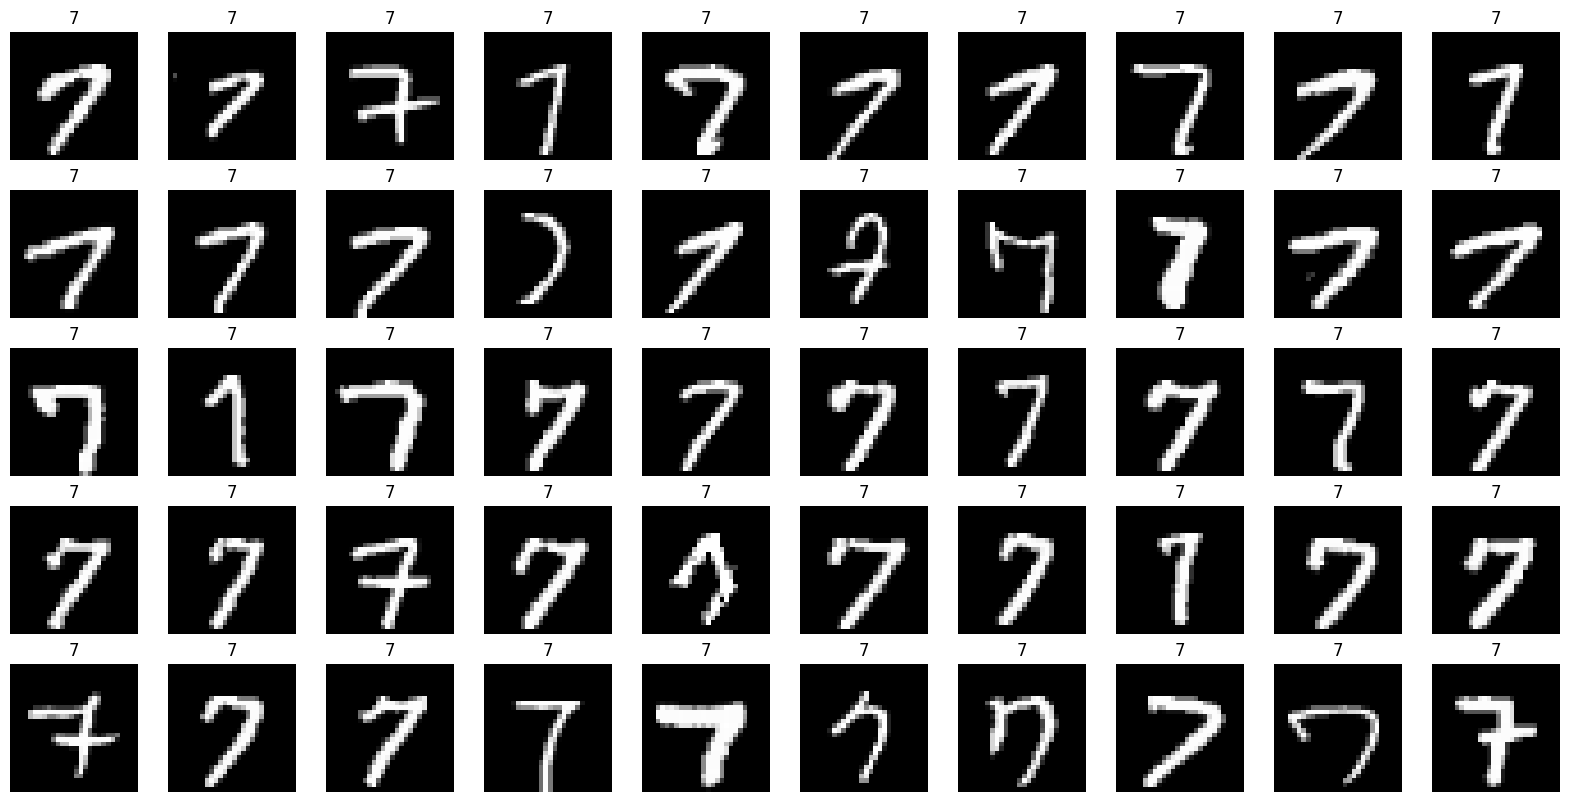

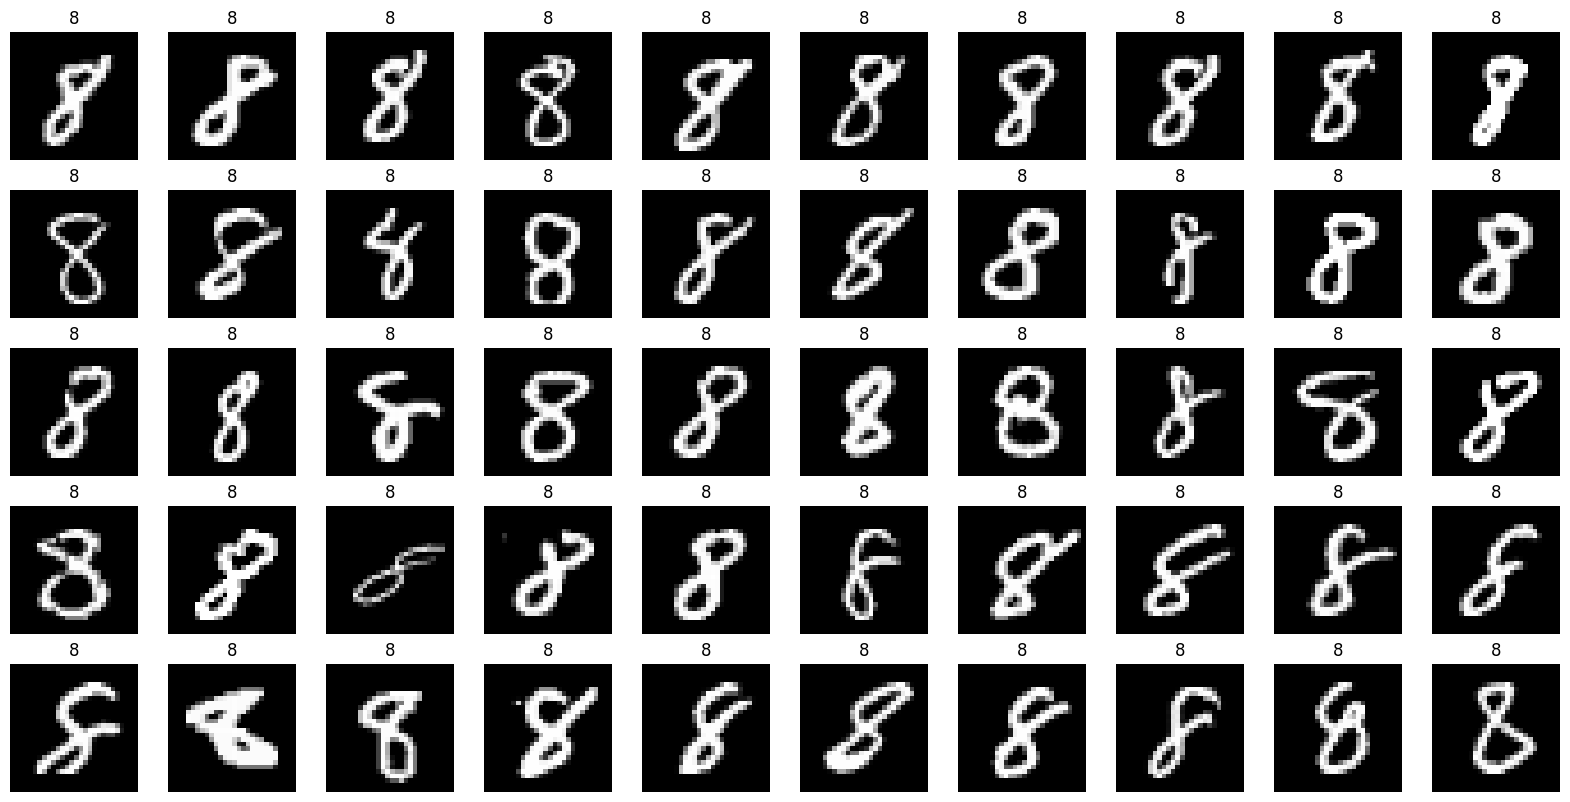

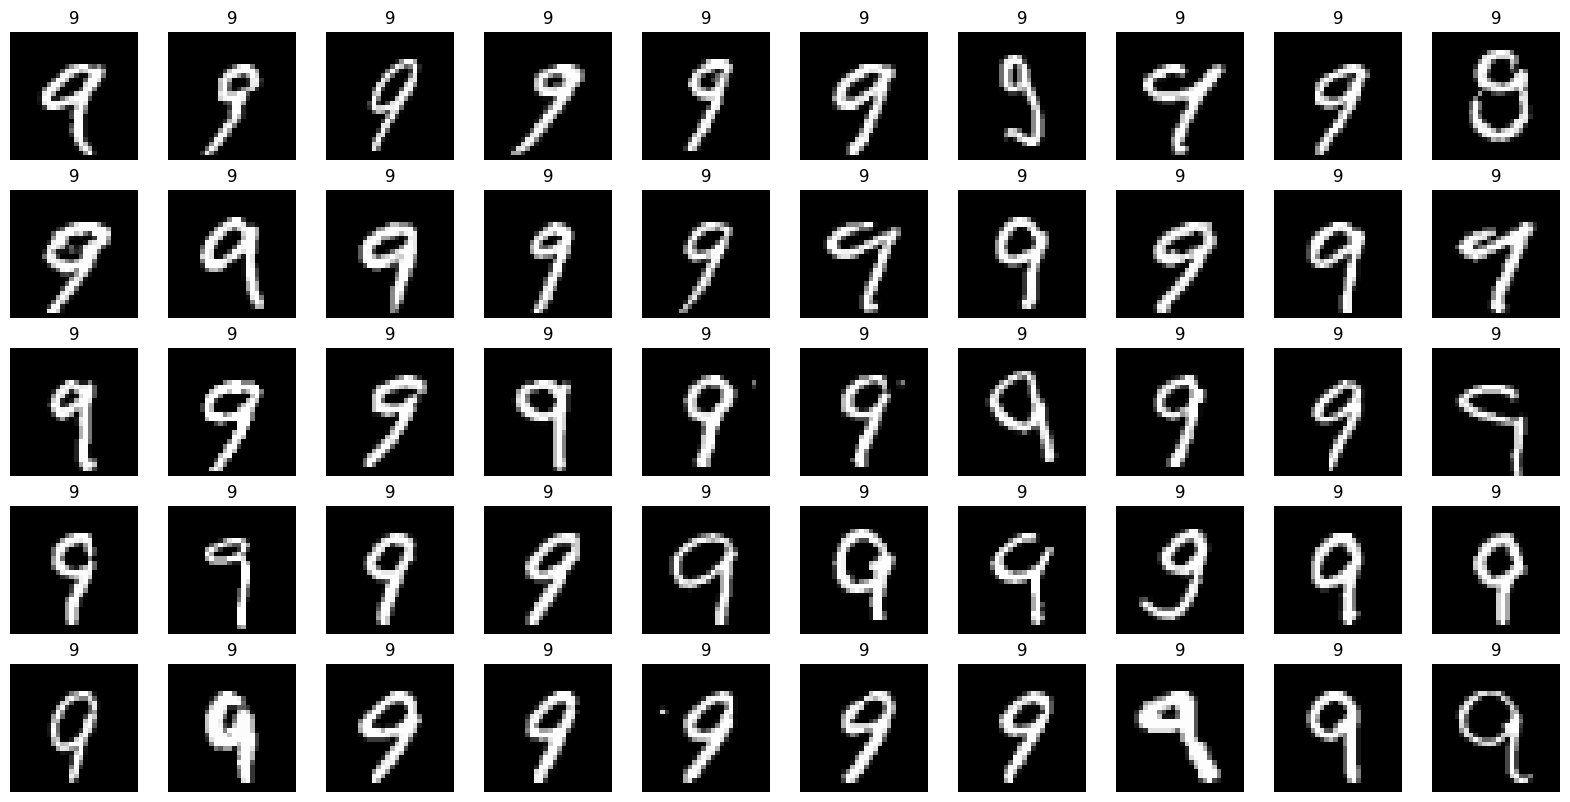

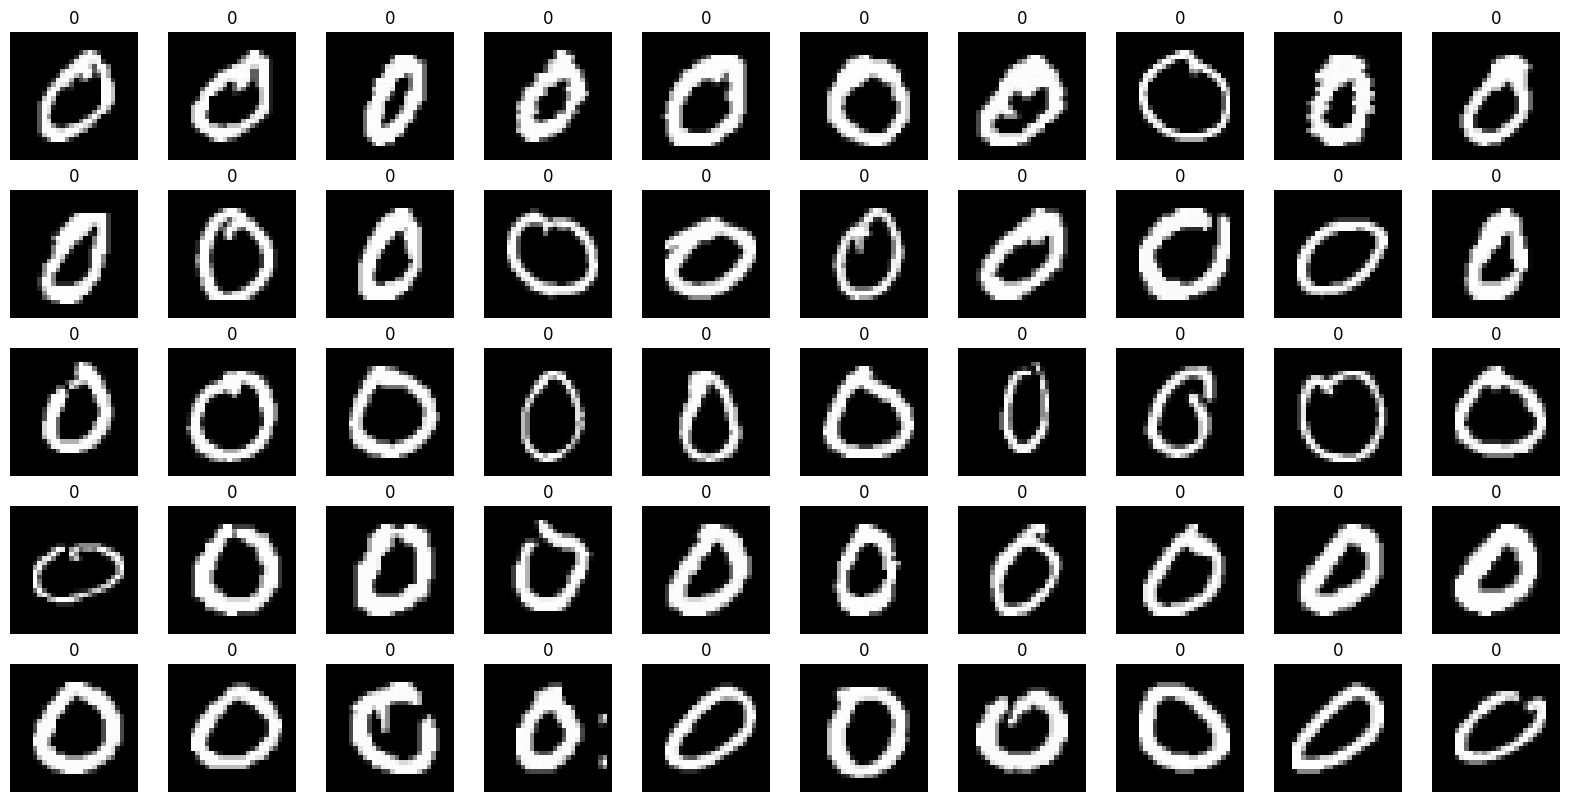

In [23]:
def convert_to_grayscale(images):
    """Convert RGB images to grayscale by averaging channels."""
    if images.dim() == 4 and images.shape[1] == 3:  # Check shape [N, C, H, W]
        images = torch.mean(images, dim=1, keepdim=True)  # Average across the color channels
    return images

def create_grayscale_dataset(dataset):
    """Convert the dataset to grayscale and store in new tensors."""
    grayscale_images = []
    labels = []

    for image, label in dataset:
        # Convert each image to grayscale
        gray_image = convert_to_grayscale(image.unsqueeze(0))  # Add batch dimension
        grayscale_images.append(gray_image)
        labels.append(label)

    # Stack all images and labels into tensors
    grayscale_images_tensor = torch.cat(grayscale_images, dim=0)  # Shape [N, 1, H, W]
    labels_tensor = torch.tensor(labels)

    return grayscale_images_tensor, labels_tensor

def sort_images_by_label(images, labels):
    """Sort images by their labels and store them along with labels in a dictionary."""
    unique_labels = labels.unique()
    sorted_datasets = {}

    for label in unique_labels:
        label_mask = labels == label
        label_images = images[label_mask]
        label_labels = labels[label_mask]
        sorted_datasets[label.item()] = (label_images, label_labels)

    return sorted_datasets

# Create the new grayscale dataset
grayscale_images, labels = create_grayscale_dataset(train_dataset)

# Sort images by label and store them in new datasets
sorted_grayscale_datasets = sort_images_by_label(grayscale_images, labels)

# Example: Access and print details of the dataset for label 1
if 1 in sorted_grayscale_datasets:
    images_1, labels_1 = sorted_grayscale_datasets[9]
    print(f"Images with label 1 shape: {images_1.shape}")
    print(f"Number of images with label 1: {labels_1.shape[0]}")
else:
    print("No images found for label 1.")

# Plot samples for label 1
images_1, labels_1 = sorted_grayscale_datasets[1]
images_2, labels_2 = sorted_grayscale_datasets[2]
images_3, labels_3 = sorted_grayscale_datasets[3]
images_4, labels_4 = sorted_grayscale_datasets[4]
images_5, labels_5 = sorted_grayscale_datasets[5]
images_6, labels_6 = sorted_grayscale_datasets[6]
images_7, labels_7 = sorted_grayscale_datasets[7] 
images_8, labels_8 = sorted_grayscale_datasets[8]
images_9, labels_9 = sorted_grayscale_datasets[9]
images_0, labels_0 = sorted_grayscale_datasets[0]


plot_samples(images_1, labels_1)
plot_samples(images_2, labels_2)
plot_samples(images_3, labels_3)
plot_samples(images_4, labels_4)
plot_samples(images_5, labels_5)
plot_samples(images_6, labels_6)
plot_samples(images_7, labels_7)
plot_samples(images_8, labels_8)
plot_samples(images_9, labels_9)
plot_samples(images_0, labels_0)

In [24]:
## Generator
# takes in a random noise vector and generates an image

class Generator(nn.Module):
    def __init__(self, input_size=100, n_classes=10, leaky_alpha=0.2):
        super().__init__()
        self.input_size = input_size
        self.n_classes = n_classes
        self.leaky_alpha = leaky_alpha

        # Define the generator architecture
        self.fc = nn.Linear(self.input_size, 4*4*512)
        self.tconv1 = nn.ConvTranspose2d(512, 256, 5, stride=2, padding=2, output_padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.tconv2 = nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2, output_padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.tconv3 = nn.ConvTranspose2d(128, 3, 5, stride=2, padding=2, output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)
        x = F.leaky_relu(self.bn1(self.tconv1(x)), negative_slope=self.leaky_alpha)
        x = F.leaky_relu(self.bn2(self.tconv2(x)), negative_slope=self.leaky_alpha)
        x = torch.tanh(self.tconv3(x))
        return x

    def generate(self, n_samples, device='cpu'):
        self.to(device)  # Ensure the model is on the right device
        noise = torch.randn(n_samples, self.input_size, device=device)  # Generate noise directly on the specified device
        labels = torch.randint(0, self.n_classes, (n_samples,), device=device)  # Generate labels directly on the specified device
        images = self.forward(noise)  # Generate images
        return images, labels

# Initialize the generator
generator_model = Generator()

# Performance measurement
num_runs = 10
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for _ in range(num_runs):
    images, labels = generator_model.generate(n_samples=1000, device=device)
end_time = time.time()

average_time = (end_time - start_time) / num_runs
print(f"Average time per execution: {average_time:.6f} seconds")
if device == "cpu":
    print("Running on the CPU can make generating samples slower")
assert average_time <= 3, "Your generator is too slow (takes more than 3s to generate 1000 samples)"

Average time per execution: 1.197616 seconds


In [25]:
## Discriminator
# takes in an image and outputs a single value, 0 or 1 if real or fake 

class Discriminator(nn.Module):
    def __init__(self, leaky_alpha):
        super(Discriminator, self).__init__()
        self.leaky_alpha = leaky_alpha

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)  # Input: (32, 32, 3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(256)
        self.fc = nn.Linear(256 * 4 * 4, 1)  # Flatten to vector and pass through dense layer

    def forward(self, x):
        # Forward pass through the network
        x = F.leaky_relu(self.conv1(x), negative_slope=self.leaky_alpha)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=self.leaky_alpha)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=self.leaky_alpha)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.sigmoid(self.fc(x))  # Sigmoid output layer for binary classification
        return x



In [26]:
## Connect Generator and Discriminator

class DCGAN(nn.Module):
    def __init__(self, sample_size, g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha):
        super(DCGAN, self).__init__()
        self.generator = Generator(sample_size, leaky_alpha)
        self.discriminator = Discriminator(leaky_alpha)

        # Setup the optimizers for both generator and discriminator
        self.opt_gen = optim.Adam(self.generator.parameters(), lr=g_learning_rate, betas=(g_beta_1, 0.999))
        self.opt_disc = optim.Adam(self.discriminator.parameters(), lr=d_learning_rate, betas=(d_beta_1, 0.999))

    def forward(self, x):
        # This method might be used for inference with the generator
        return self.generator(x)

    def train_discriminator(self, real_data, fake_data):
        # Reset gradients
        self.opt_disc.zero_grad()
        
        # Train with real data
        real_pred = self.discriminator(real_data)
        real_loss = F.binary_cross_entropy(real_pred, torch.ones_like(real_pred))
        
        # Train with fake data
        fake_pred = self.discriminator(fake_data.detach())  # detach to avoid training gen on these labels
        fake_loss = F.binary_cross_entropy(fake_pred, torch.zeros_like(fake_pred))
        
        # Calculate total loss and update discriminator
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        self.opt_disc.step()
        
        return disc_loss.item()

    def train_generator(self):
        # Reset gradients
        self.opt_gen.zero_grad()
        
        # Generate fake data and calculate loss
        noise = torch.randn(batch_size, sample_size, device=device)
        fake_data = self.generator(noise)
        fake_pred = self.discriminator(fake_data)
        gen_loss = F.binary_cross_entropy(fake_pred, torch.ones_like(fake_pred))
        
        # Update generator
        gen_loss.backward()
        self.opt_gen.step()
        
        return gen_loss.item()


In [27]:
## Training our DCGAN
# training plan:
#   set the discriminator trainable
#   train the discriminator with real images with the label smoothing (labels=1-smooth)
#   train the discriminator with fake images generated by the generator (labels=0)
#   set the discriminator non-trainable
#   train the DCGAN with generated images (labels=1)
#   repeat all of this until the disciminator loss and the generator loss stabilize.

def train_dcgan(g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha, smooth=0.1,
                sample_size=100, epochs=25, batch_size=128, eval_size=16, show_details=True, show_interval=5):
    # DataLoader setup
    transform = transforms.ToTensor()
    train_dataset = SVHN(root='~/datasets', split='train', transform=transform, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model initialization
    dcgan = DCGAN(sample_size, g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha).to(device)

    losses = []
    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(train_loader):
            real_images = real_images.to(device)

            # Label smoothing for real images
            labels_real = (torch.ones(batch_size, 1) * (1 - smooth)).to(device)
            labels_fake = torch.zeros(batch_size, 1).to(device)

            # Train the discriminator with real images
            dcgan.train_discriminator(real_images, labels_real)

            # Generate fake images
            noise = torch.randn(batch_size, sample_size, device=device)
            fake_images = dcgan.generator(noise)

            # Train the discriminator with fake images
            dcgan.train_discriminator(fake_images, labels_fake)

            # Train the generator
            gen_loss = dcgan.train_generator()

            # Collect and log losses
            losses.append((dcgan.disc_loss, gen_loss))

            # Optionally print training progress
            if show_details and i % show_interval == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], "
                      f"Discriminator Loss: {dcgan.disc_loss:.4f}, Generator Loss: {gen_loss:.4f}")
                with torch.no_grad():
                    sample_noise = torch.randn(eval_size, sample_size, device=device)
                    sample_images = dcgan.generator(sample_noise).detach().cpu()
                show_images(sample_images, num_images=eval_size)

    # Optional visualization of losses
    if show_details:
        plot_losses(losses)

    return dcgan.generator

def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot([x[0] for x in losses], label="Discriminator", alpha=0.5)
    plt.plot([x[1] for x in losses], label="Generator", alpha=0.5)
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def show_images(images, num_images=16):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images[:num_images]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.permute(1, 2, 0))  # Adjust for PyTorch channel position
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example use of the function
print("Generator trained")



Generator trained


### _Get me some juicy color_

In [34]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
import matplotlib.colors as mcolors


# def colorize_images(images, cmap_list):
#     """Apply a random colormap to grayscale images."""
#     colored_images = []
#     for image in images:
#         image = image.squeeze()  # Remove the channel dimension if it exists
#         cmap_choice = random.choice(cmap_list)  # Randomly select a colormap
#         colored_image = plt.get_cmap(cmap_choice)(image.numpy())  # Apply colormap to numpy array
#         colored_image = colored_image[..., :3]  # Drop the alpha channel
#         colored_images.append(torch.from_numpy(colored_image).permute(2, 0, 1))  # Convert to tensor and rearrange dimensions
#     return colored_images

# # List of colormaps to choose from
# colormap_list = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'spring', 'summer', 'autumn', 'winter', 'cool', 'hot']

# # Convert images again with corrected function using random colormaps
# colored_images_1 = colorize_images(images_1, colormap_list)

# # Plot the colored images with adjusted plotting function
# def plot_colored_samples(images, labels):
#     fig = plt.figure(figsize=(20, 10))
#     grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.3)

#     for ax, im, label in zip(grid, images, labels):
#         # Correctly adjust the dimensions for display
#         im = im.permute(1, 2, 0)  # Rearrange the dimensions to (height, width, channels)
#         ax.imshow(im)
#         ax.axis('off')
#         ax.set_title(f'{label}')

#     plt.show()

# plot_colored_samples(colored_images_1, labels_1)


def desaturate(color_array):
    """Desaturate and lighten the colors to mimic paint on house numbers."""
    # Convert to HSV to easily adjust saturation and value
    hsv = mcolors.rgb_to_hsv(color_array[:, :, :3])
    hsv[:, :, 1] *= 0.25  # Reduce the saturation
    hsv[:, :, 2] += 0.3  # Increase the brightness/lightness
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 1)  # Ensure brightness doesn't exceed 1
    return mcolors.hsv_to_rgb(hsv)

def colorize_images(images, cmap_list):
    """Apply a randomly chosen, but subdued colormap to grayscale images."""
    colored_images = []
    for image in images:
        image = image.squeeze()  # Remove the channel dimension if it exists
        cmap_choice = random.choice(cmap_list)  # Randomly select a colormap
        colored_image = plt.get_cmap(cmap_choice)(image.numpy())  # Apply colormap to numpy array
        colored_image = desaturate(colored_image)  # Desaturate and lighten the colors
        colored_image = colored_image[:, :, :3]  # Drop the alpha channel
        colored_images.append(torch.from_numpy(colored_image).permute(2, 0, 1))  # Convert to tensor and rearrange dimensions
    return colored_images

# List of colormaps to choose from
colormap_list = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
colored_list = ['mud']

# Convert images again with corrected function using random colormaps
colored_images_1 = colorize_images(images_1, colormap_list)

# Now plot the colored images
#plot_colored_samples(colored_images_1, labels_1)



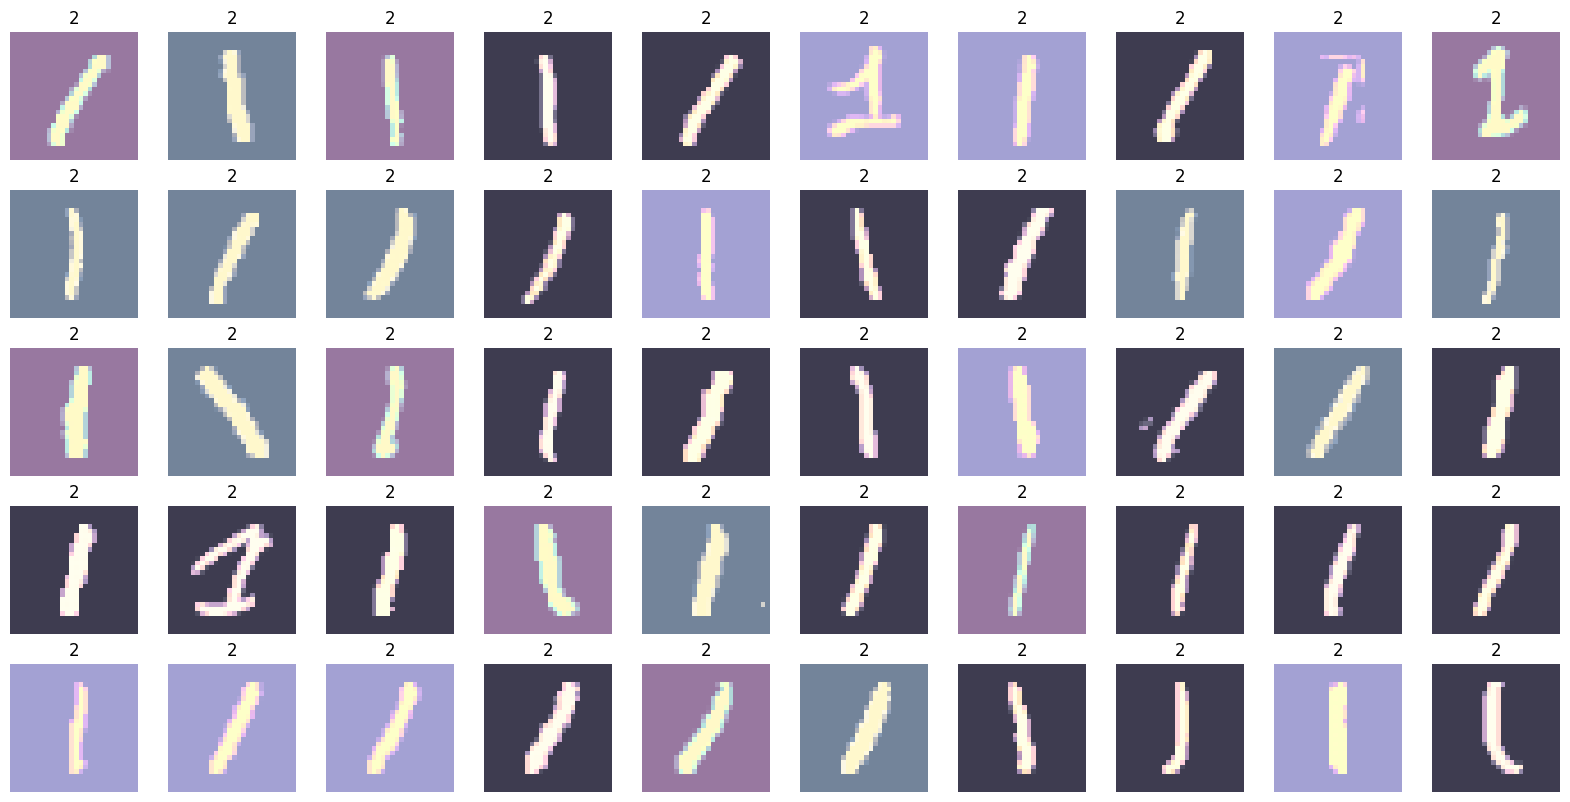

In [36]:
def plot_colored_samples(images, labels):
    from mpl_toolkits.axes_grid1 import ImageGrid
    fig = plt.figure(figsize=(20, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.3)

    for ax, im, label in zip(grid, images, labels):
        # Correctly adjust the dimensions for display
        im = im.permute(1, 2, 0)  # Rearrange the dimensions to (height, width, channels)
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'{label}')

    plt.show()

# Assuming labels_1 is defined somewhere in your code
plot_colored_samples(colored_images_1, labels_1)